In [1]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm.auto import tqdm
import torchmetrics
import cv2
device0 = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

batch_size=256

In [2]:
#fit
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res
class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/Mix_artifacts/ratio/train/'
train_df=pd.read_csv('../../data/Mix_artifacts/ratio/train.csv')

train_data=torch.empty(len(train_df),1,3000)
train_label=torch.empty(len(train_data),1)

for i in tqdm(range(len(train_df))):
    file_name=train_df.loc[i]['FileName']
    AF_signal_label=train_df.loc[i]['AF']
    signal_csv=pd.read_csv(train_csv_path+file_name)['PPG'].to_numpy()
    train_data[i]=torch.tensor(signal_csv)
    train_label[i]=torch.tensor([AF_signal_label])
    
test_csv_path ='../../data/Mix_artifacts/ratio/test/'
test_df=pd.read_csv('../../data/Mix_artifacts/ratio/test.csv')

test_data=torch.empty(len(test_df),1,3000)
test_label=torch.empty(len(test_data),1)

for i in tqdm(range(len(test_df))):
    file_name=test_df.loc[i]['FileName']
    AF_signal_label=test_df.loc[i]['AF']
    signal_csv=pd.read_csv(test_csv_path+file_name)['PPG'].to_numpy()
    test_data[i]=torch.tensor(signal_csv)
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/27110 [00:00<?, ?it/s]

  0%|          | 0/6605 [00:00<?, ?it/s]

In [5]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class MLSTMfcn(nn.Module):
    def __init__(self, *, num_classes, max_seq_len, num_features,
                 num_lstm_out=128, num_lstm_layers=2, 
                 conv1_nf=128, conv2_nf=256, conv3_nf=128,
                 lstm_drop_p=0.8, fc_drop_p=0.3):
        super(MLSTMfcn, self).__init__()

        self.num_classes = num_classes
        self.max_seq_len = max_seq_len
        self.num_features = num_features

        self.num_lstm_out = num_lstm_out
        self.num_lstm_layers = num_lstm_layers

        self.conv1_nf = conv1_nf
        self.conv2_nf = conv2_nf
        self.conv3_nf = conv3_nf

        self.lstm_drop_p = lstm_drop_p
        self.fc_drop_p = fc_drop_p

        self.lstm = nn.LSTM(input_size=self.num_features, 
                            hidden_size=self.num_lstm_out,
                            num_layers=self.num_lstm_layers,
                            batch_first=True)
        
        self.conv1 = nn.Conv1d(self.num_lstm_out, self.conv1_nf, 8)
        self.conv2 = nn.Conv1d(self.conv1_nf, self.conv2_nf, 5)
        self.conv3 = nn.Conv1d(self.conv2_nf, self.conv3_nf, 3)

        self.bn1 = nn.BatchNorm1d(self.conv1_nf)
        self.bn2 = nn.BatchNorm1d(self.conv2_nf)
        self.bn3 = nn.BatchNorm1d(self.conv3_nf)

        self.se1 = SELayer(self.conv1_nf)  # ex 128
        self.se2 = SELayer(self.conv2_nf)  # ex 256

        self.relu = nn.ReLU()
        self.lstmDrop = nn.Dropout(self.lstm_drop_p)
        self.convDrop = nn.Dropout(self.fc_drop_p)

        self.fc = nn.Linear(self.conv3_nf+self.num_lstm_out, self.num_classes)
    
    def forward(self, x):
        ''' input x should be in size [B,T,F], where 
            B = Batch size
            T = Time samples
            F = features
        '''
        x=x.transpose(2,1)
        x1, (ht,ct) = self.lstm(x)
        
        x2 = x1.transpose(2,1)
        x2 = self.convDrop(self.relu(self.bn1(self.conv1(x2))))
        x2 = self.se1(x2)
        x2 = self.convDrop(self.relu(self.bn2(self.conv2(x2))))
        x2 = self.se2(x2)
        x2 = self.convDrop(self.relu(self.bn3(self.conv3(x2))))
        x2 = torch.mean(x2,2)
        x1 = torch.mean(x1,1)
        x_all = torch.cat((x1,x2),dim=1)
        x_out = self.fc(x_all)
        x_out = F.log_softmax(x_out, dim=1)

        return x_out


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = MLSTMfcn(num_classes=1,max_seq_len=3000,num_features=1).to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,[(batch_size,1,3000)])

Layer (type:depth-idx)                   Output Shape              Param #
MLSTMfcn                                 [256, 1]                  --
├─LSTM: 1-1                              [256, 3000, 128]          199,168
├─Conv1d: 1-2                            [256, 128, 2993]          131,200
├─BatchNorm1d: 1-3                       [256, 128, 2993]          256
├─ReLU: 1-4                              [256, 128, 2993]          --
├─Dropout: 1-5                           [256, 128, 2993]          --
├─SELayer: 1-6                           [256, 128, 2993]          --
│    └─AdaptiveAvgPool1d: 2-1            [256, 128, 1]             --
│    └─Sequential: 2-2                   [256, 128]                --
│    │    └─Linear: 3-1                  [256, 8]                  1,024
│    │    └─ReLU: 3-2                    [256, 8]                  --
│    │    └─Linear: 3-3                  [256, 128]                1,024
│    │    └─Sigmoid: 3-4                 [256, 128]                -

  0%|          | 0/10000 [00:00<?, ?it/s]

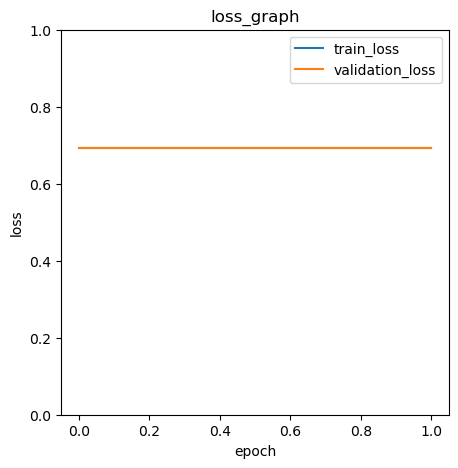

KeyboardInterrupt: 

In [6]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
epoch_count=tqdm(range(10000))
for epoch in epoch_count:
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
    
    train_loss_list.append((running_loss/train_count))
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
         
        epoch_count.set_description(f"\repoch: {epoch+1}/{10000} train_loss : {running_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
    if epoch%500==1:
        plt.figure(figsize=(5,5)) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/architecture_waveform/MALSTM-FCN_ratio_callback.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/architecture_waveform/MALSTM-FCN_ratio.pt')